<a href="https://colab.research.google.com/github/Danieltandrade/Transfer-Learning-com-Python/blob/main/Transfer_Learning_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Visão Computacional com Transfer-Learning

O objeto deste projeto é utilizar uma rede neural já treinada para realizar uma classificação de imagens em um novo conjunto de dados, com isso, será utilizado o conhecimento aprendido desta rede neural para realizar o novo treinamento.

## 1º Passo: Importando as bibliotecas necessárias

In [ ]:
import os
import shutil
import zipfile
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

## 2º Passo: Download do novo Dataset
Este Dataset será formado por duas classes, chamadas "cats" e "dogs", contendo pastas com 200 imagens para treinamento e 50 imagens para validação de cada classe. Opcionalmente pode ser habilitado as pastas de testes para as duas classes.

- O Download do Dataset pode ser realizado no link a seguir ou conforme escrito no código abaixo: [Download](https://www.microsoft.com/en-us/download/details.aspx?id=54765)
- Após o Download será criado um novo Dataset com as imagens sendo escolhidas de forma randomica.

In [ ]:
# 1. Download do arquivo zip
zip_path = "/content/kagglecatsanddogs_5340.zip"
print("Baixando o arquivo zip...")
!wget --no-check-certificate "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" -O {zip_path}
print("Download concluído!")

# 2. Extrair o arquivo zip
extract_path = "/content/kagglecatsanddogs_5340"
print("Extraindo os arquivos...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extração concluída!")

# 3. Variável para decidir se a pasta "test" será criada
create_test = True  # Mude para False se não quiser criar a pasta "test"

# 4. Criar a estrutura de pastas
destination_path = "/content/dataset"
os.makedirs(f"{destination_path}/train/cats", exist_ok=True)
os.makedirs(f"{destination_path}/train/dogs", exist_ok=True)
os.makedirs(f"{destination_path}/val/cats", exist_ok=True)
os.makedirs(f"{destination_path}/val/dogs", exist_ok=True)

if create_test:
    os.makedirs(f"{destination_path}/test/cats", exist_ok=True)
    os.makedirs(f"{destination_path}/test/dogs", exist_ok=True)

# 5. Ajustar a função para copiar imagens para "test" (se necessário)
def select_and_copy_images(source_folder, train_folder, val_folder, test_folder, train_count, val_count, test_count):
    images = os.listdir(source_folder)
    images = [img for img in images if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    random.seed(7)
    selected_images = random.sample(images, train_count + val_count + (test_count if create_test else 0))  # Ajusta com base no test_count
    train_images = selected_images[:train_count]
    val_images = selected_images[train_count:train_count + val_count]

    # Caso create_test seja verdadeiro, separa imagens para o conjunto de teste
    test_images = selected_images[train_count + val_count:] if create_test else []

    # Copiar para treinamento
    for img in tqdm(train_images, desc=f"Copiando para {train_folder}"):
        shutil.copy(os.path.join(source_folder, img), os.path.join(train_folder, img))

    # Copiar para validação
    for img in tqdm(val_images, desc=f"Copiando para {val_folder}"):
        shutil.copy(os.path.join(source_folder, img), os.path.join(val_folder, img))

    # Copiar para teste, se habilitado
    if create_test:
        for img in tqdm(test_images, desc=f"Copiando para {test_folder}"):
            shutil.copy(os.path.join(source_folder, img), os.path.join(test_folder, img))

# 6. Organizar as imagens
print("Organizando as imagens...")

# Copiar imagens de gatos
select_and_copy_images(
    source_folder=f"{extract_path}/PetImages/Cat",
    train_folder=f"{destination_path}/train/cats",
    val_folder=f"{destination_path}/val/cats",
    test_folder=f"{destination_path}/test/cats",
    train_count=200,
    val_count=50,
    test_count=20  # Defina a quantidade desejada para o conjunto de teste
)

# 7. Copiar imagens de cachorros
select_and_copy_images(
    source_folder=f"{extract_path}/PetImages/Dog",
    train_folder=f"{destination_path}/train/dogs",
    val_folder=f"{destination_path}/val/dogs",
    test_folder=f"{destination_path}/test/dogs",
    train_count=200,
    val_count=50,
    test_count=20  # Defina a quantidade desejada para o conjunto de teste
)

# 8. Remover arquivos e pastas não utilizados
print("Removendo arquivos desnecessários...")
if os.path.exists(zip_path):
    os.remove(zip_path)
    print(f"Arquivo {zip_path} removido.")

if os.path.exists(extract_path):
    shutil.rmtree(extract_path)
    print(f"Pasta {extract_path} removida.")

# 9. Verificar a estrutura final
print("\nEstrutura final de arquivos:")
for root, dirs, files in os.walk(destination_path):
    print(f"{root}: {len(files)} arquivos")

Baixando o arquivo zip...
--2025-01-02 01:25:47--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.213.36.252, 2600:1409:12:39f::317f, 2600:1409:12:385::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.213.36.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/content/kagglecatsanddogs_5340.zip’

/content/kagglecats 100%[===================>] 786.67M  87.2MB/s    in 9.0s    

2025-01-02 01:25:56 (87.7 MB/s) - ‘/content/kagglecatsanddogs_5340.zip’ saved [824887076/824887076]

Download concluído!
Extraindo os arquivos...
Extração concluída!
Organizando as imagens...


Copiando para /content/dataset/test/dogs: 100%|██████████| 20/20 [00:00<00:00, 6145.50it/s]

Removendo arquivos desnecessários...


Arquivo /content/kagglecatsanddogs_5340.zip removido.
Pasta /content/kagglecatsanddogs_5340 removida.

Estrutura final de arquivos:
/content/dataset: 0 arquivos
/content/dataset/train: 0 arquivos
/content/dataset/train/dogs: 200 arquivos
/content/dataset/train/cats: 200 arquivos
/content/dataset/val: 0 arquivos
/content/dataset/val/dogs: 50 arquivos
/content/dataset/val/cats: 50 arquivos
/content/dataset/test: 0 arquivos
/content/dataset/test/dogs: 20 arquivos
/content/dataset/test/cats: 20 arquivos


## 3º Passo: Definir Diretórios e Preparando os Dados

Este código define e carrega conjuntos de dados para treinamento, validação e opcionalmente, teste, utilizando `image_dataset_from_directory`. As imagens são redimensionadas para 250x250 e processadas em lotes de 32, com normalização aplicada para escalá-las entre 0 e 1. O parâmetro `create_test` controla a inclusão do conjunto de teste. Os dados de validação e teste não são embaralhados, garantindo consistência na avaliação.



In [ ]:
# Diretórios de treinamento, validação e teste (caso aplicável)
train_dir = "/content/dataset/train"
val_dir = "/content/dataset/val"
test_dir = "/content/dataset/test" if create_test else None

# Carregar os datasets usando image_dataset_from_directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(250, 250),
    batch_size=32,
    label_mode="categorical",  # Para classificação multi-classe
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(250, 250),
    batch_size=32,
    label_mode="categorical",
    shuffle=False  # Não embaralhar para avaliar a performance corretamente
)

# Carregar o conjunto de teste apenas se `create_test` for True
if create_test:
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=(250, 250),
        batch_size=32,
        label_mode="categorical",
        shuffle=False  # Não embaralhar para garantir consistência
    )

# Normalização dos dados
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Normalizar o conjunto de teste, se existir
if create_test:
    test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


Found 400 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


## 4º Passo: Criando modelo utilizando InceptionV3

Este passo utiliza o modelo pré-treinado __InceptionV3__ como base, congelando seus pesos e adicionando camadas customizadas para classificação de imagens em duas classes. O modelo é compilado com o otimizador __Adam__ e a função de perda `categorical_crossentropy`. Se o conjunto de teste for criado, ele é usado após o treinamento para avaliar a generalização do modelo, garantindo desempenho consistente em dados não vistos.


In [ ]:
# Carregar o modelo pré-treinado InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# Congelar os pesos do modelo base
base_model.trainable = False

# Adicionar camadas customizadas no topo
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation="softmax")(x) # Duas clases

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilando modelo com a função de perda correta
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",  # Função de perda para múltiplas classes
    metrics=["accuracy"]
)

# Avalia o desempenho no conjunto de teste (se aplicável)
if create_test:
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"Loss no teste: {test_loss}")
    print(f"Acurácia no teste: {test_acc}")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - accuracy: 0.5167 - loss: 0.6674
Loss no teste: 0.6634872555732727
Acurácia no teste: 0.5249999761581421


## 5º Passo: Treinando o modelo

O modelo é treinado utilizando o conjunto de treinamento e validado com o conjunto de validação por até 30 épocas. O callback `EarlyStopping` monitora a perda no conjunto de validação (`val_loss`) e interrompe o treinamento se não houver melhora por 5 épocas consecutivas, restaurando os melhores pesos. Esse processo reduz o risco de sobreajuste e otimiza o tempo de treinamento.


In [ ]:
# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinamento
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stopping]
)


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7590 - loss: 0.4405 - val_accuracy: 0.9700 - val_loss: 0.0958
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.9873 - loss: 0.0571 - val_accuracy: 0.9300 - val_loss: 0.1571
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.9909 - loss: 0.0448 - val_accuracy: 0.9700 - val_loss: 0.0933
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9953 - loss: 0.0292 - val_accuracy: 0.9400 - val_loss: 0.1165
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.9949 - loss: 0.0138 - val_accuracy: 0.9400 - val_loss: 0.1229
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9995 - loss: 0.0046 - val_accuracy: 0.9400 - val_loss: 0.1301
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.9600 - val_loss: 0.0872
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.9300

## 6º Passo: Avaliando Modelo

### 6.1 Avaliando Modelo

O modelo é avaliado no conjunto de validação gerando previsões e comparando-as com os rótulos verdadeiros. Métricas como precisão, recall e F1-score são apresentadas em um relatório de classificação, e uma matriz de confusão é criada para analisar erros. Este processo permite identificar o desempenho do modelo em diferentes classes e ajustar sua eficácia.

In [ ]:
# Gerar previsões
Y_pred = model.predict(val_dataset)
y_pred = np.argmax(Y_pred, axis=1)  # Converter probabilidades para classes

# Obter os rótulos verdadeiros do dataset
true_labels = np.concatenate([y for x, y in val_dataset], axis=0)
true_labels = np.argmax(true_labels, axis=1)  # Garantir que os rótulos sejam inteiros

# Relatório de Classificação
print("Relatório de Classificação:")
print(classification_report(true_labels, y_pred, target_names=['Cat', 'Dog']))

# Matriz de Confusão
cm = confusion_matrix(true_labels, y_pred)
print("Matriz de Confusão:")
print(cm)


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Relatório de Classificação:
              precision    recall  f1-score   support

         Cat       1.00      0.92      0.96        50
         Dog       0.93      1.00      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100

Matriz de Confusão:
[[46  4]
 [ 0 50]]


### 6.2 Avaliando Teste

Se o conjunto de teste estiver habilitado, o modelo também será avaliado nesse conjunto, gerando previsões e comparando-as com os rótulos verdadeiros.

In [ ]:
if create_test:
    # Gerar previsões no conjunto de teste
    print("\nAvaliando no conjunto de teste:")
    Y_test_pred = model.predict(test_dataset)
    y_test_pred = np.argmax(Y_test_pred, axis=1)

    # Obter os rótulos verdadeiros do conjunto de teste
    true_test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
    true_test_labels = np.argmax(true_test_labels, axis=1)

    # Relatório de Classificação no conjunto de teste
    print("\nRelatório de Classificação no Conjunto de Teste:")
    print(classification_report(true_test_labels, y_test_pred, target_names=['Cat', 'Dog']))

    # Matriz de Confusão no conjunto de teste
    test_cm = confusion_matrix(true_test_labels, y_test_pred)
    print("\nMatriz de Confusão no Conjunto de Teste:")
    print(test_cm)
else:
    print("Conjunto de teste não foi criado. Avaliação limitada ao conjunto de validação.")



Avaliando no conjunto de teste:
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Relatório de Classificação no Conjunto de Teste:
              precision    recall  f1-score   support

         Cat       1.00      1.00      1.00        20
         Dog       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


Matriz de Confusão no Conjunto de Teste:
[[20  0]
 [ 0 20]]


## 7º Passo: Visualizando o Resultado

O desempenho do modelo durante o treinamento é exibido em duas curvas: uma para a acurácia e outra para a perda. As curvas são separadas em dois gráficos, mostrando tanto a evolução da acurácia e da perda durante o treinamento quanto a validação.

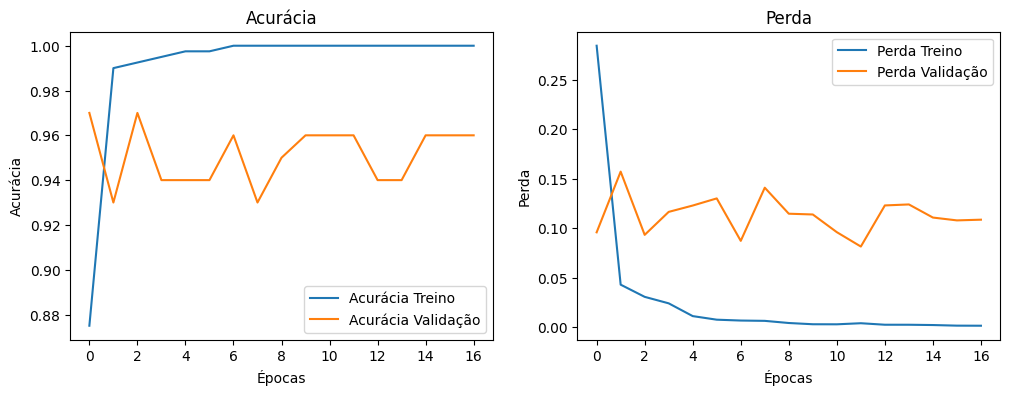

In [ ]:
# Plotar a curva de aprendizado
plt.figure(figsize=(12, 4))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda Treino')
plt.plot(history.history['val_loss'], label='Perda Validação')
plt.title('Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.show()